# Importing Libraries and Configurations

In [2]:
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install vaderSentiment
!pip install finnhub-python
!pip install praw

  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-4rzsdk30
  Running command git clone --filter=blob:none --quiet https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-4rzsdk30
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit 614d4c2029a62d348ca56598f87c425966aaec66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for snscrape: filename=snscrape-0.7.0.20230622-py3-none-any.whl size=74814 sha256=11cd004cf4e9c88dd225ff5f0ea6b4f19fccd2eb4c1320b33877d17817140540
  Stored in directory: /tmp/pip-ephem-wheel-cache-kpg2a993/wheels/05/e9/f7/57056e7c7e44b1feed932fa49fdec9d706c4f563e37160ab74
Successfully built snscrape
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.0 MB/s eta 0:00:0

In [7]:
#mounting google drive to access files

from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "/content/gdrive/My Drive/ETH_Price_Prediction"

Mounted at /content/gdrive


In [4]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import regex as re
from IPython.display import clear_output
from scipy.special import softmax
from os import listdir
from os.path import isfile, join
import finnhub
import calendar as cal
import matplotlib.pyplot as plt
import praw

In [ ]:
finnhub_client = finnhub.Client(api_key="ci22ik9r01qifnupm7kgci22ik9r01qifnupm7l0")

In [5]:
reddit_read_only = praw.Reddit(client_id="QgAaKQMUr4ilpRzRvbRjpA",
                               client_secret="br4D8WQ5JYNFR0E8fpuo-ceqOXjbsA",
                               user_agent="ethereum price prediction")

In [29]:
number_of_days = 125
finish_time = datetime(2023,6,9)
start_time = datetime(2023,2,5)
time_span = 60
num_of_candles = 3000

# Sentiment Analysis


The function below uses Vader as the main sentiment analysis library. Vader is trained on real-world Twitter data and will use emojis, punctuations, etc to its advantage. It requires minimum text cleaning as all the characters could be valuable. The function returns 3 values corresponding to the Neutral, Negative and Positive states of the text.

In [12]:
def row_sentiment_analysis(row):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(row["Text"])
  row["Neutral"] = sentiment_dict['neu']
  row["Negetive"] = sentiment_dict['neg']
  row["Positive"] = sentiment_dict['pos']
  return row

The function below removes all the links and all hashtags at the end of a sentence

In [11]:
def cleaning_data(text):
  hashtag_remove = re.compile('([\s]*#\w+\h*)+$')
  no_hashtag = re.sub(hashtag_remove, '', text)
  link_remove = re.compile('((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')
  no_link = re.sub(link_remove, '', text)
  return no_link

# Scraping Tweeter Data


This section scrapes twitter data using Snscrape library. It get relevant tweets, filters them and saves each day's tweets in a xlsx file. After all the files are collected, dataset will be created.

In [ ]:
until = finish_time + timedelta(days = 1)
tweets_df = pd.DataFrame()

for i in range(number_of_days):
  daily_info_container = []
  until = until - timedelta(days = 1)
  since = until - timedelta(days = 1)
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(
      f'ethereum since:{since.strftime("%Y-%m-%d")} until:{until.strftime("%Y-%m-%d")} lang:en exclude:retweets exclude:replies').get_items()):
    if tweet.user.followersCount > 100 and tweet.likeCount > 10:
      daily_info_container.append([tweet.date.strftime("%Y-%m-%d %H:%M:%S"),
                                   tweet.likeCount, tweet.viewCount, tweet.user.blue, tweet.user.followersCount, tweet.rawContent])

  daily_info_df = pd.DataFrame(daily_info_container, columns=["DateTime", "Number of Likes", "Views", "Blue", "Followers", "Text"])
  daily_info_df["Text"] = daily_info_df["Text"].apply(lambda s: cleaning_data(s))
  daily_info_df = daily_info_df.apply(row_sentiment_analysis, axis=1)

  tweets_df = pd.concat([tweets_df, daily_info_df])

  daily_info_df.to_excel(join(drive_path,f'tweets_{since.strftime("%Y-%m-%d")}.xlsx'), index=False)

for i in range(10):
    clear_output(wait=True)
    print(i, flush=True)

Combining all the tweets in a single file

In [ ]:
tweets_df = pd.DataFrame()

drive_files = [f for f in listdir(drive_path) if isfile(join(drive_path, f))]

for item in drive_files:
  if item.startswith("tweets_"):
    temp_df = pd.read_excel(join(drive_path,item))
    tweets_df = pd.concat([tweets_df, temp_df])

tweets_df.to_excel(join(drive_path,f'twitter_data_{start_time.strftime("%Y-%m-%d")}_{finish_time.strftime("%Y-%m-%d")}.xlsx'), index=False)

In [ ]:
tweets_df = pd.read_excel(join(drive_path,f'twitter_data_2023-2-5_2023-6-9.xlsx'))

In [65]:
tweets_df

,DateTime,Number of Likes,Views,Blue,Followers,Tweet,Neutral,Negetive,Positive
0,2023-06-08 23:56:38,41,4569,False,34892,I mean look at Ethereum,1.000,0.000,0.000
1,2023-06-08 23:55:59,85,4841,False,27965,"Congrats, Vu! 👏 \n\nVeChain is blockchain for ...",0.661,0.000,0.339
2,2023-06-08 23:46:47,93,7041,True,81435,✨@Taikoxyz raised a $22M investment from the s...,1.000,0.000,0.000
3,2023-06-08 23:46:43,18862,343696,True,25903,"⚡️ $FINALE X $DAVE, HIS LATEST AIRDROP.\n DES...",1.000,0.000,0.000
4,2023-06-08 23:44:04,20,385,False,456,My new pfp...#SCROTOSCHIZO.\n\n@Schizocurrency...,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...
34708,2023-02-08 09:04:02,24,16267,True,11510,What upgrades are included in the #Ethereum Sh...,0.967,0.033,0.000
34709,2023-02-08 09:03:28,16,531,False,1393,"Today, February 8th, @mr_abims will go through...",1.000,0.000,0.000
34710,2023-02-08 09:03:09,22,700,True,47533,We are extremely excited to announce our partn...,0.877,0.000,0.123
34711,2023-02-08 09:00:03,47,650,False,1319,☄️Live Mint Now! RFOX VALT Apartments\n\n🐦Twit...,1.000,0.000,0.000


Spliting tweets based on number of views into five parts. Each part gets a corresponding mutiplier to then be multiplied to sentiment scores.

In [66]:
split_parts = tweets_df["Views"].quantile([0.2,0.4,0.6,0.8]).tolist()

def scale_views(row):
  if row["Views"] < split_parts[0] :
    return 1
  elif row["Views"] < split_parts[1] :
    return 2
  elif row["Views"] < split_parts[2] :
    return 3
  elif row["Views"] < split_parts[3] :
    return 4
  else :
    return 5

In [69]:
tweets_df_prototype = tweets_df.copy()

tweets_df_prototype["Views Scaled"] = tweets_df_prototype.apply (lambda row: scale_views(row), axis=1)
tweets_df_prototype["Neutral"] = tweets_df_prototype["Neutral"] * tweets_df_prototype["Views Scaled"]
tweets_df_prototype["Negetive"] = tweets_df_prototype["Negetive"] * tweets_df_prototype["Views Scaled"]
tweets_df_prototype["Positive"] = tweets_df_prototype["Positive"] * tweets_df_prototype["Views Scaled"]

The following section trims DateTime to only keep the Date and the hour since we are working on a hourly basis. Afterwards all the tweets are grouped by based on their DateTime. New value are created by getting avg/sum of the old values.

In [70]:
tweets_df_prototype["DateTime"] = tweets_df_prototype["DateTime"].str[:-6]

df_agg = tweets_df_prototype.groupby(['DateTime']).agg(Neutral_T=('Neutral', 'mean'),
                                         Negetive_T=('Negetive', 'mean'),
                                         Positive_T=('Positive','mean'),
                                         Likes_T=('Number of Likes','sum'),
                                         Views_T=('Views','sum'),
                                         Follower_T=('Followers','mean'),
                                         Total_T=('Positive','count'),
                                         ).reset_index()

df_agg_sentiments = df_agg[["Neutral_T","Negetive_T","Positive_T"]]

df_agg_sentiments = softmax(df_agg_sentiments, axis = 1)

df_agg = df_agg.drop(columns=["Neutral_T","Negetive_T","Positive_T"], axis=1)
df_agg_sentiments = pd.DataFrame(df_agg_sentiments, columns=["Neutral_T","Negetive_T","Positive_T"])
tweets_df_prototype = pd.concat([df_agg,df_agg_sentiments], axis = 1)

In [71]:
tweets_df_prototype

,DateTime,Likes_T,Views_T,Follower_T,Total_T,Neutral_T,Negetive_T,Positive_T
0,2023-02-05 08,704,197384,4.510896e+05,8,0.764641,0.120893,0.114466
1,2023-02-05 09,265,18584,1.286412e+04,8,0.810824,0.080222,0.108954
2,2023-02-05 10,442,18253,1.820667e+04,12,0.725172,0.127230,0.147598
3,2023-02-05 11,1348,86000,3.806220e+04,25,0.767543,0.097105,0.135351
4,2023-02-05 12,1845,117729,1.636368e+04,31,0.837120,0.075824,0.087056
...,...,...,...,...,...,...,...,...
1295,2023-06-08 19,16839,265934,2.298149e+05,26,0.878839,0.056366,0.064794
1296,2023-06-08 20,2028,263993,2.599675e+04,24,0.885472,0.053866,0.060663
1297,2023-06-08 21,3585,128903,5.155450e+04,14,0.858614,0.053845,0.087541
1298,2023-06-08 22,81482,445376,1.045780e+06,19,0.882685,0.054376,0.062940


The following plot selects random rows and shows a stacked bar diagram of the rows. As can be observed, the majority of the sentiments are neutral, with negative and positive varying in between.

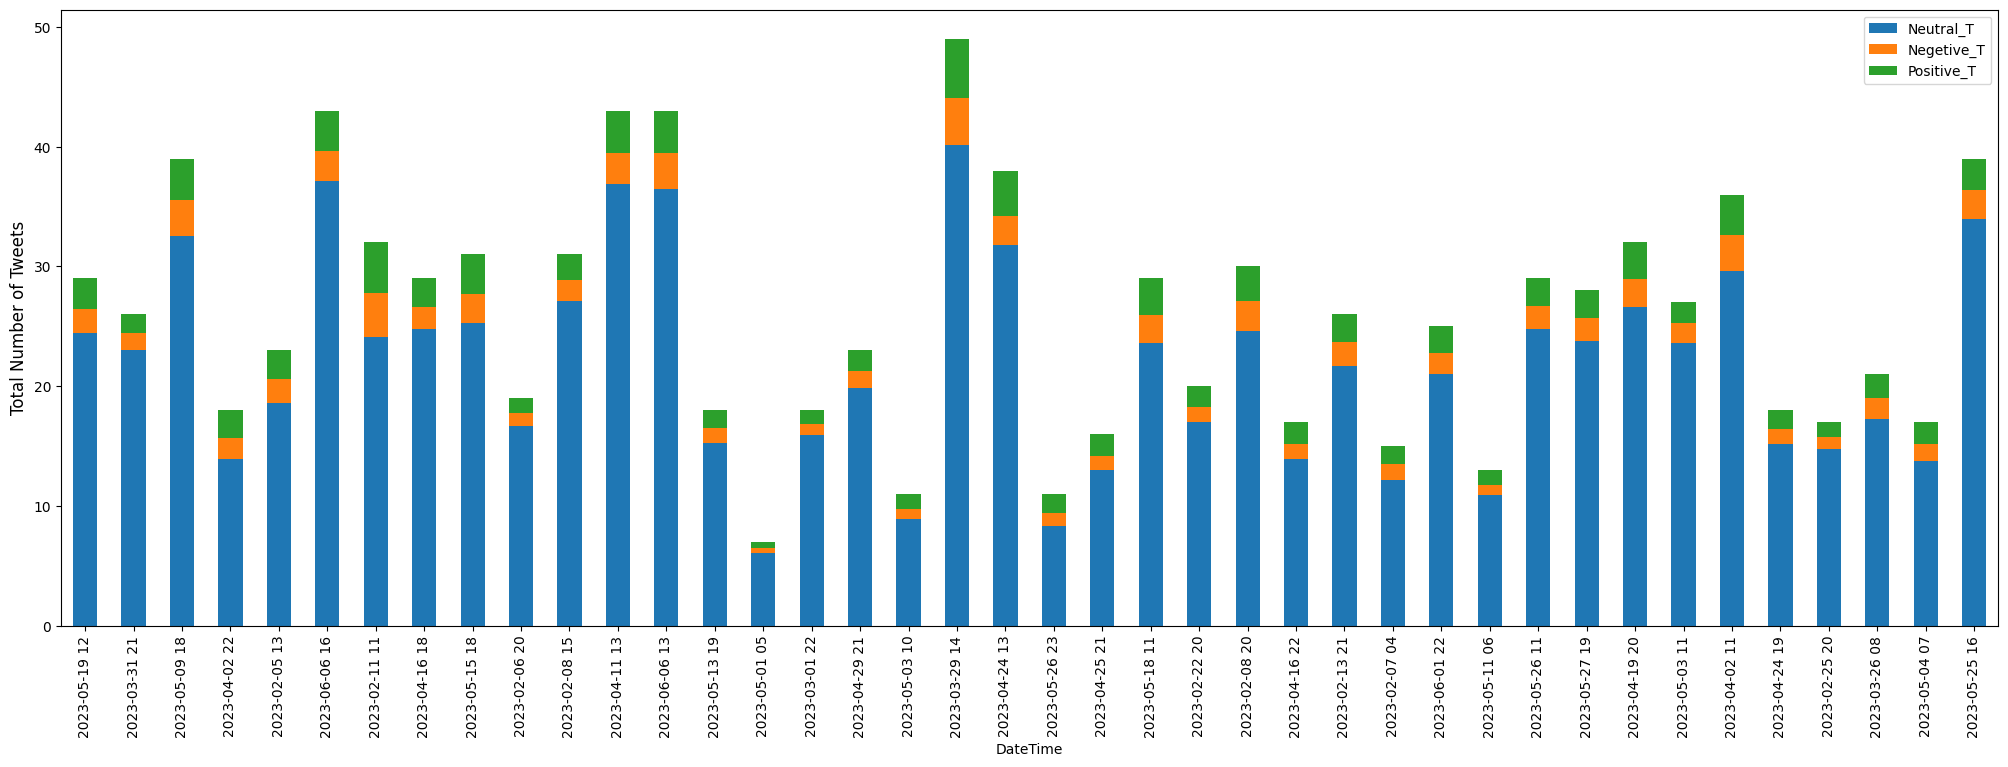

In [72]:
tweets_scaled = tweets_df_prototype.copy()
tweets_scaled["Neutral_T"] = tweets_scaled["Neutral_T"] * tweets_scaled["Total_T"]
tweets_scaled["Negetive_T"] = tweets_scaled["Negetive_T"] * tweets_scaled["Total_T"]
tweets_scaled["Positive_T"] = tweets_scaled["Positive_T"] * tweets_scaled["Total_T"]

fig = plt.figure(figsize = (25,8))
tweets_scaled[["Neutral_T","Negetive_T","Positive_T","DateTime"]].sample(40).plot(
    x="DateTime", kind="bar", stacked=True, ax=plt.gca())
plt.ylabel("Total Number of Tweets", fontsize = 12)
plt.legend()
plt.show()

# Scrapping Reddit Data

In [ ]:
subreddit = reddit_read_only.subreddit("ethereum+bitcoin")

posts = subreddit.search(limit = None, query="ethereum", time_filter = 'year')

posts_dict = {"Text": [], "ID": [], "Score": [],
              "Upvote Ratio": [], "Created On":[]}

keword_list = ["ethereum","eth","btc","bitcoin","crypto","cryptocurrency","nft","web3","blockchain","metaverse"]

for post in posts:

    if any(substring.lower() in post.title for substring in keword_list):

      posts_dict["Text"].append(post.title + ". " + post.selftext)
      posts_dict["ID"].append(post.id)
      posts_dict["Score"].append(post.score)
      posts_dict["Upvote Ratio"].append(post.upvote_ratio)
      posts_dict["Created On"].append(post.created_utc)

all_posts = pd.DataFrame(posts_dict)
all_posts['Created On'] = pd.to_datetime(all_posts['Created On'],  unit='s')
all_posts = all_posts[(all_posts["Created On"] > datetime.datetime(2023,2,5)) &
                      (all_posts["Created On"] < datetime.datetime(2023,6,9))]
all_posts.to_excel(join(drive_path,f'reddit_posts_2023-2-5_2023-6-9.xlsx'), index=False)

for i in range(10):
  clear_output(wait=True)
  print(i, flush=True)

In [ ]:
all_comments = {"ID": [], "Created On": [], "Text": [], "Score": []}

for index, row in all_posts.iterrows():
    submission = reddit_read_only.submission(row["ID"])
    for comment in submission.comments:
        if not isinstance(comment, praw.models.MoreComments):
          all_comments["ID"].append(comment.id)
          all_comments["Created On"].append(comment.created_utc)
          all_comments["Text"].append(comment.body)
          all_comments["Score"].append(comment.score)

all_comments = pd.DataFrame(all_comments)
all_comments['Created On'] = pd.to_datetime(all_comments['Created On'],  unit='s')
all_comments["Created On"] = all_comments["Created On"].apply(lambda x : x.strftime('%Y-%m-%d %H'))
all_comments["Upvote Ratio"] = 0.5
all_comments.to_excel(join(drive_path,f'reddit_comments_2023-2-5_2023-6-9.xlsx'), index=False)

for i in range(10):
  clear_output(wait=True)
  print(i, flush=True)

In [8]:
all_posts = pd.read_excel(join(drive_path,f'reddit_posts_2023-2-5_2023-6-9.xlsx'))
all_comments = pd.read_excel(join(drive_path,f'reddit_comments_2023-2-5_2023-6-9.xlsx'))

In [9]:
reddit_df = pd.concat([all_posts,all_comments], axis=0, ignore_index=True)
reddit_df = reddit_df.drop_duplicates(keep='first')
reddit_df['Created On'] = pd.to_datetime(reddit_df['Created On'])
reddit_df = reddit_df.sort_values("Created On")
reddit_df = reddit_df.reset_index(drop=True)

In [13]:
reddit_df["Text"] = reddit_df["Text"].apply(lambda s: cleaning_data(s))
reddit_df = reddit_df.apply(row_sentiment_analysis, axis=1)

In [52]:
reddit_df

,ID,Score,Upvote Ratio,Created On,Text,Neutral,Negetive,Positive,DateTime
0,j7a6ohk,36,0.5,2023-02-05 06:00:00,"DCA every week, don’t worry about the price. Y...",0.690,0.167,0.144,2023-02-05 06
1,j7a7803,2,0.5,2023-02-05 06:00:00,Early 2017. So in past,1.000,0.000,0.000,2023-02-05 06
2,j7a6ftj,10,0.5,2023-02-05 06:00:00,Yesterday was the best day to buy bitcoin. Tod...,0.588,0.000,0.412,2023-02-05 06
3,j7a5y4u,7,0.5,2023-02-05 06:00:00,2013,1.000,0.000,0.000,2023-02-05 06
4,10u62rf,0,0.4,2023-02-05 06:41:47,When is the perfect time to by bitcoin?. I hav...,0.704,0.000,0.296,2023-02-05 06
...,...,...,...,...,...,...,...,...,...
5634,jpoh3y0,1,0.5,2023-06-27 03:00:00,that guys a legendary btc pizza,1.000,0.000,0.000,2023-06-27 03
5635,jprc1tn,1,0.5,2023-06-27 19:00:00,I'm having the same issue with having withdraw...,0.942,0.058,0.000,2023-06-27 19
5636,jq0t07e,1,0.5,2023-06-29 17:00:00,He's a 🐐,1.000,0.000,0.000,2023-06-29 17
5637,jqh5tty,1,0.5,2023-07-03 06:00:00,Does anybody care anymore that crypto currency...,0.534,0.221,0.244,2023-07-03 06


In [49]:
reddit_df.to_excel(join(drive_path,f'reddit_data_{start_time.strftime("%Y-%m-%d")}_{finish_time.strftime("%Y-%m-%d")}.xlsx'), index=False)

In [51]:
reddit_df = pd.read_excel(join(drive_path,f'reddit_data_2023-02-05_2023-06-09.xlsx'))

In [34]:
split_parts = reddit_df["Score"].quantile([0.2,0.4,0.6,0.8]).tolist()

def scale_score(row):
  if row["Score"] < split_parts[0] :
    return 1
  elif row["Score"] < split_parts[1] :
    return 2
  elif row["Score"] < split_parts[2] :
    return 3
  elif row["Score"] < split_parts[3] :
    return 4
  else :
    return 5

In [53]:
reddit_df_prototype = reddit_df.copy()

reddit_df_prototype["Score Scaled"] = reddit_df_prototype.apply (lambda row: scale_score(row), axis=1)
reddit_df_prototype["Neutral"] = reddit_df_prototype["Neutral"] * reddit_df_prototype["Score Scaled"]
reddit_df_prototype["Negetive"] = reddit_df_prototype["Negetive"] * reddit_df_prototype["Score Scaled"]
reddit_df_prototype["Positive"] = reddit_df_prototype["Positive"] * reddit_df_prototype["Score Scaled"]

In [54]:
reddit_df_prototype["DateTime"] = reddit_df_prototype["Created On"].astype(str).str[:-6]

df_agg = reddit_df_prototype.groupby(['DateTime']).agg(Neutral_R=('Neutral', 'mean'),
                                         Negetive_R=('Negetive', 'mean'),
                                         Positive_R=('Positive','mean'),
                                         Score_R=('Score','mean'),
                                         Upvote_R=('Upvote Ratio','mean'),
                                         Total_R=('Positive','count'),
                                         ).reset_index()

df_agg_sentiments = df_agg[["Neutral_R","Negetive_R","Positive_R"]]

df_agg_sentiments = softmax(df_agg_sentiments, axis = 1)

df_agg = df_agg.drop(columns=["Neutral_R","Negetive_R","Positive_R"], axis=1)
df_agg_sentiments = pd.DataFrame(df_agg_sentiments, columns=["Neutral_R","Negetive_R","Positive_R"])
reddit_df_prototype = pd.concat([df_agg,df_agg_sentiments], axis = 1)

In [55]:
reddit_df_prototype

,DateTime,Score_R,Upvote_R,Total_R,Neutral_R,Negetive_R,Positive_R
0,2023-02-05 06,11.000,0.48,5,0.891838,0.042161,0.066002
1,2023-02-05 07,5.625,0.50,8,0.964089,0.017495,0.018415
2,2023-02-05 08,1.250,0.50,4,0.920652,0.038286,0.041062
3,2023-02-05 09,1.000,0.50,3,0.877379,0.061617,0.061004
4,2023-02-05 10,1.000,0.50,6,0.902786,0.049008,0.048206
...,...,...,...,...,...,...,...
1532,2023-06-27 03,1.000,0.50,1,0.909443,0.045279,0.045279
1533,2023-06-27 19,1.000,0.50,1,0.885144,0.062412,0.052444
1534,2023-06-29 17,1.000,0.50,1,0.909443,0.045279,0.045279
1535,2023-07-03 06,1.000,0.50,1,0.552495,0.216036,0.231469


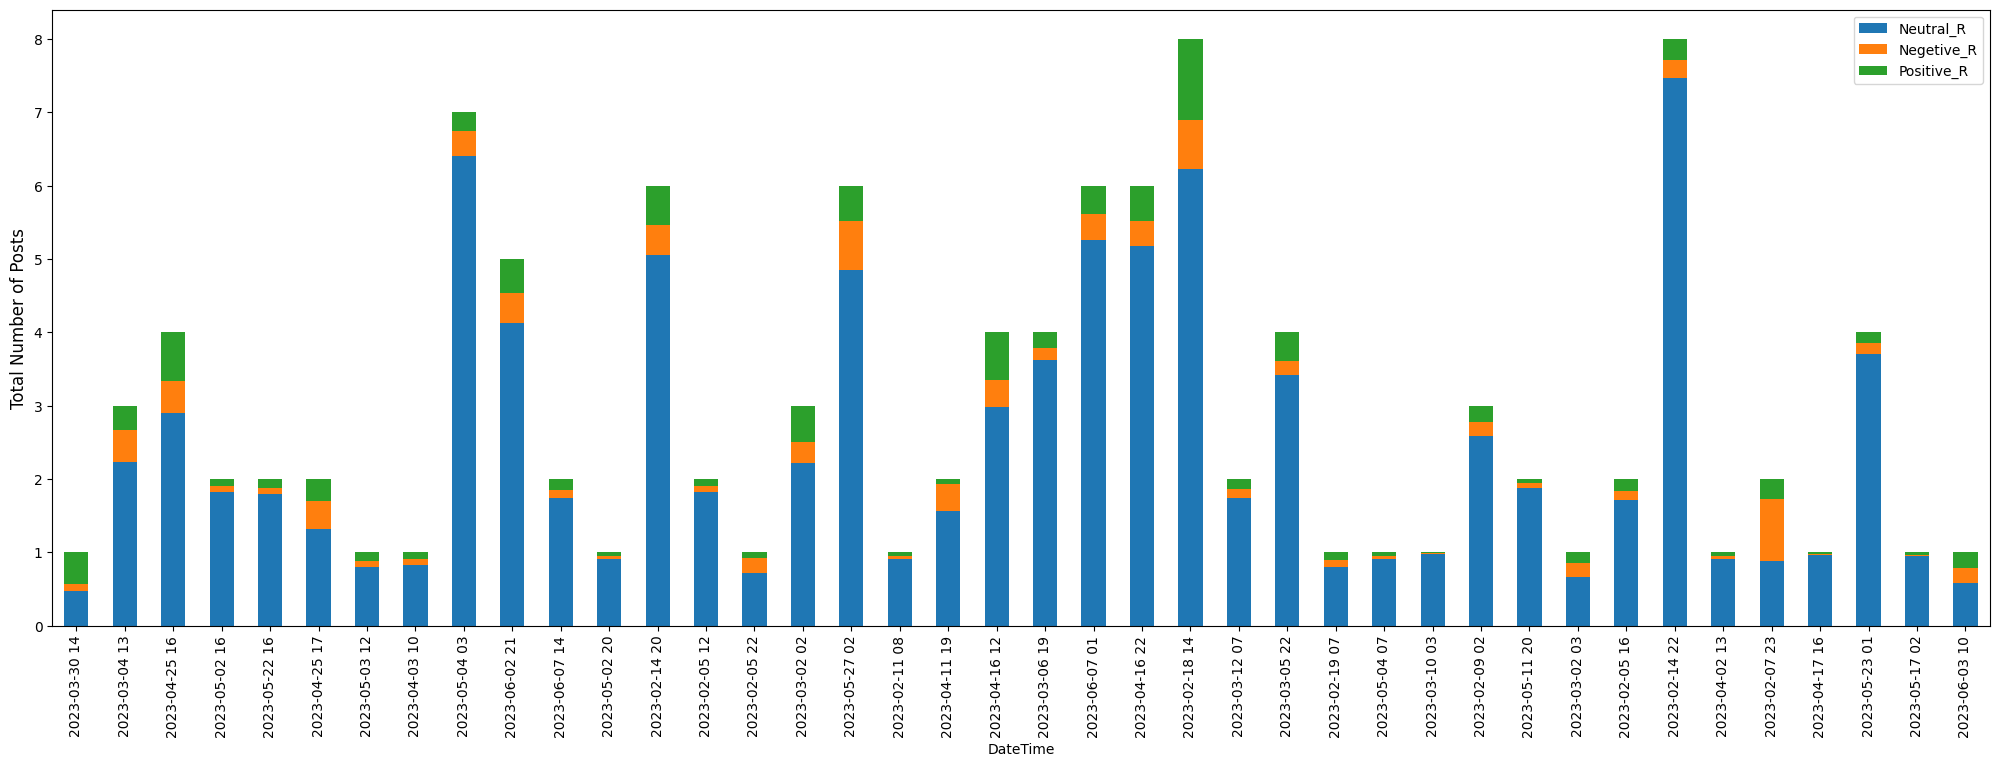

In [57]:
reddit_data_scaled = reddit_df_prototype.copy()
reddit_data_scaled["Neutral_R"] = reddit_data_scaled["Neutral_R"] * reddit_data_scaled["Total_R"]
reddit_data_scaled["Negetive_R"] = reddit_data_scaled["Negetive_R"] * reddit_data_scaled["Total_R"]
reddit_data_scaled["Positive_R"] = reddit_data_scaled["Positive_R"] * reddit_data_scaled["Total_R"]

fig = plt.figure(figsize = (25,8))
reddit_data_scaled[["Neutral_R","Negetive_R","Positive_R","DateTime"]].sample(40).plot(
    x="DateTime", kind="bar", stacked=True, ax=plt.gca())
plt.ylabel("Total Number of Posts", fontsize = 12)
plt.legend()
plt.show()

# Getting Crypto Data


In [ ]:
def convert_to_dateTime(row):
    return datetime.fromtimestamp(row['DateTime']).strftime("%Y-%m-%d %H:%M:%S")[:-6]

The following code downloads etherium data from finnhub. Since the website only allows for 1000 candles per request, data is gathered among multiple requests to the api.

In [ ]:
def get_crypto_data(finnhub_client, start, finish, span, symbol):
    result = pd.DataFrame()
    timspan = finish - start

    if span == 'D':
      total_span_seconds = 24 * 60 * 60
    else :
      total_span_seconds = span * 60

    total_time_seconds = timspan.total_seconds()
    interval = int(total_time_seconds / (total_span_seconds * 1000)) + 1
    for i in range(interval):
        start_time = start + timedelta(seconds = total_span_seconds * i * 1000)
        finish_time = start + timedelta(seconds = total_span_seconds * (i + 1) * 1000)
        if(finish_time > finish):
            finish_time = finish
        start_time_int = cal.timegm(start_time.timetuple())
        finish_time_int = cal.timegm(finish_time.timetuple())
        res = finnhub_client.crypto_candles(f'BINANCE:{symbol}', str(span), start_time_int, finish_time_int)
        res = pd.DataFrame(res)
        result = pd.concat([result, res])
        result.reset_index(drop=True, inplace=True)
    return result[:-1]


In [ ]:
if time_span == 'D':
  start_time = finish_time - timedelta(seconds = num_of_candles * 24 * 60 * 60)
else :
  start_time = finish_time - timedelta(seconds = num_of_candles * time_span * 60)

The next part creates datafrom from data and add a few auxiliary columns to improve features.

In [ ]:
crypto_df = get_crypto_data(finnhub_client, start_time + timedelta(days = 1), finish_time, time_span, 'ETHUSDT')
crypto_df.rename(columns={'c': 'Close', 'h': 'High', 'l': 'Low', 'o': 'Open', 't': 'DateTime', 'v': 'Volume'}, inplace=True)
crypto_df.drop(['s'], axis=1, inplace=True)
crypto_df['DateTime'] = crypto_df.apply(lambda row : convert_to_dateTime(row), axis=1)
crypto_df.loc[0, 'Change%'] = 0.0
crypto_df['Range%'] = (crypto_df['High'] - crypto_df['Low']) * 100 / crypto_df['Close']
for i in range(1,len(crypto_df)):
  crypto_df.loc[i,"Change%"] = (crypto_df.loc[i,"Close"] - crypto_df.loc[i - 1,"Close"]) * 100 / crypto_df.loc[i - 1,"Close"]

crypto_df['24h_change%'] = crypto_df['Close'].diff(24) * 100 / crypto_df.loc[i - 1,"Close"]
crypto_df.to_excel(join(drive_path,f'crypto_data_2023-2-5_2023-6-9.xlsx'), index=False)

In [46]:
crypto_df = pd.read_excel(join(drive_path,f'crypto_data_2023-2-5_2023-6-9.xlsx'))

In [47]:
crypto_df

,Close,High,Low,Open,DateTime,Volume,Change%,Range%,24h_change%
0,1663.47,1671.00,1657.49,1666.39,2023-02-05 00,19117.0490,0.000000,0.812158,NaN
1,1665.48,1667.39,1660.55,1663.47,2023-02-05 01,8897.9437,0.120832,0.410692,NaN
2,1661.01,1668.78,1661.00,1665.48,2023-02-05 02,9242.4960,-0.268391,0.468390,NaN
3,1660.70,1663.51,1656.68,1661.01,2023-02-05 03,16613.1097,-0.018663,0.411272,NaN
4,1664.17,1666.13,1659.35,1660.69,2023-02-05 04,8899.8348,0.208948,0.407410,NaN
...,...,...,...,...,...,...,...,...,...
2971,1847.73,1847.98,1844.69,1846.22,2023-06-08 19,3983.9246,0.081247,0.178056,-0.142203
2972,1852.72,1853.37,1846.58,1847.73,2023-06-08 20,5569.2081,0.270061,0.366488,0.602335
2973,1851.83,1854.00,1849.91,1852.71,2023-06-08 21,3884.4927,-0.048037,0.220863,1.578290
2974,1849.47,1852.69,1847.09,1851.83,2023-06-08 22,5585.6312,-0.127442,0.302789,1.067873


Plotting the price and volume

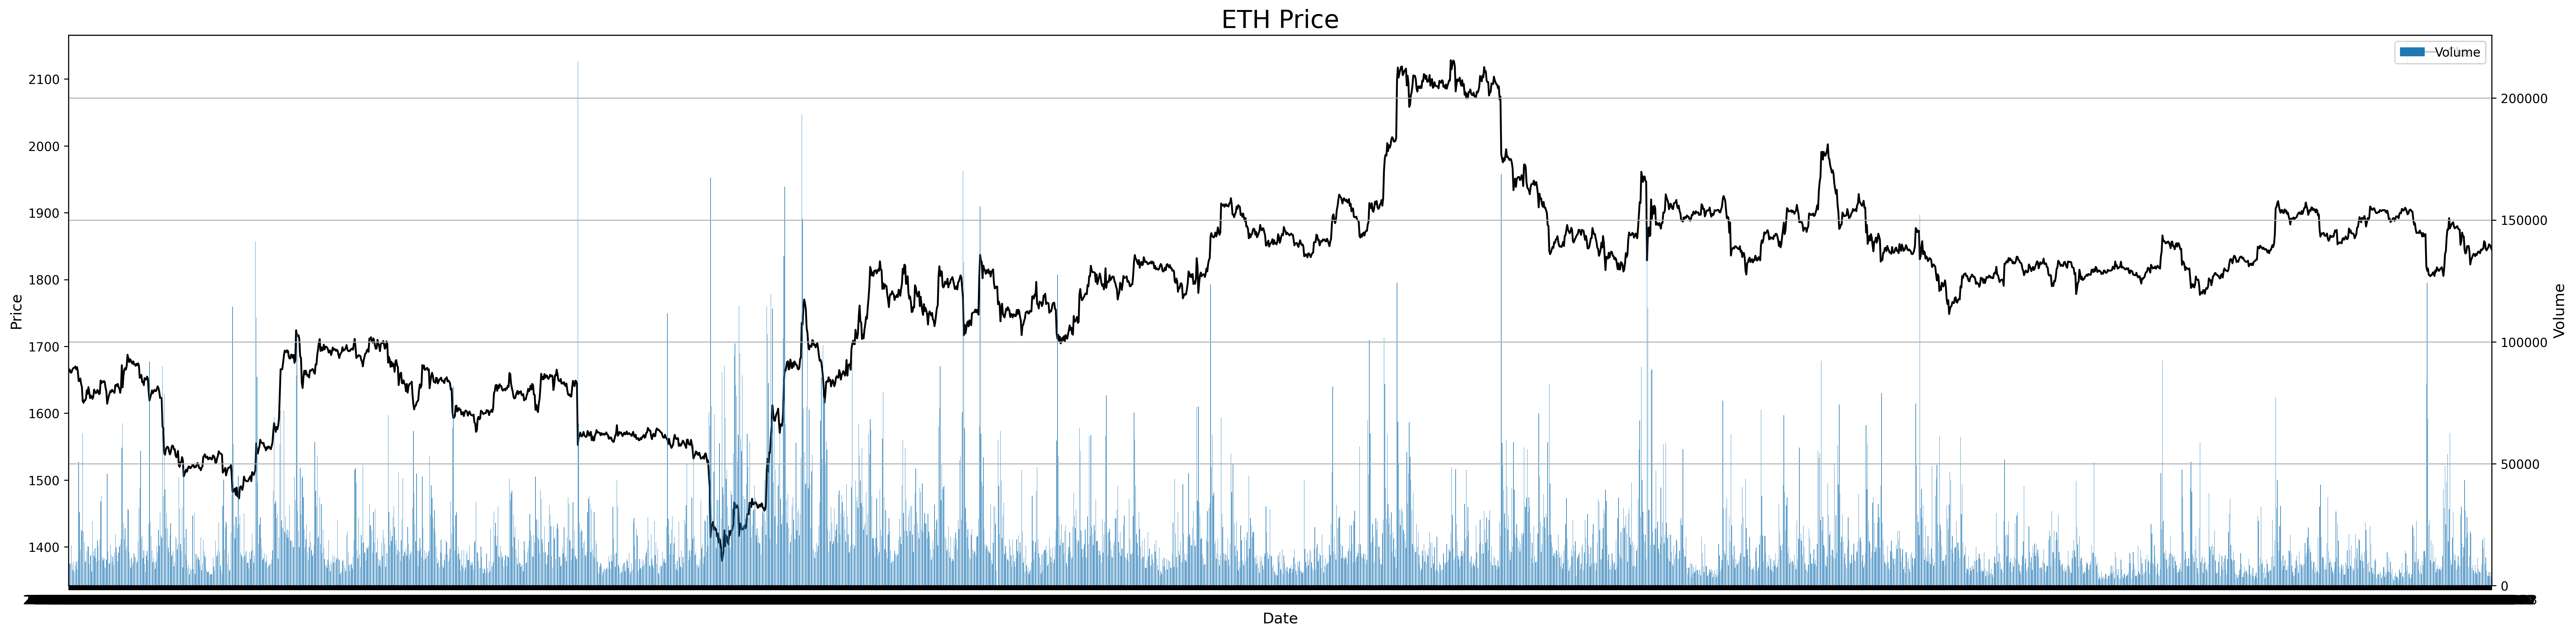

In [ ]:
fig = plt.figure(figsize = (35,8), dpi=300)
crypto_df.plot(x="DateTime", y="Close", ax=plt.gca(), color='black')
ax = plt.gca()
ax1 = ax.twinx()
crypto_df.plot(x="DateTime", y="Volume", kind='bar', ax=ax1)
ax.set_ylabel('Price', fontsize = 12 )
ax.set_xlabel('Date', fontsize = 12 )
ax1.set_ylabel('Volume', fontsize = 12 )
plt.title('ETH Price', fontsize = 20)
ax.legend()
ax1.legend()
plt.grid()
plt.show()

# Combining Data


Combining data using left joing and fixing NaN values and empty sentiment values.

In [75]:
df = pd.merge(crypto_df,tweets_df_prototype,on='DateTime',how='left')
df = pd.merge(df,reddit_df_prototype,on='DateTime',how='left')

df.fillna({'Neutral_R':1, 'Neutral_T':1}, inplace=True)
df.fillna(0, inplace=True)

df.to_excel(join(drive_path,f'sentiment_analysis_dataset.xlsx'), index=False)

In [76]:
df

,Close,High,Low,Open,DateTime,Volume,Change%,Range%,24h_change%,Likes_T,...,Total_T,Neutral_T,Negetive_T,Positive_T,Score_R,Upvote_R,Total_R,Neutral_R,Negetive_R,Positive_R
0,1663.47,1671.00,1657.49,1666.39,2023-02-05 00,19117.0490,0.000000,0.812158,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
1,1665.48,1667.39,1660.55,1663.47,2023-02-05 01,8897.9437,0.120832,0.410692,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
2,1661.01,1668.78,1661.00,1665.48,2023-02-05 02,9242.4960,-0.268391,0.468390,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
3,1660.70,1663.51,1656.68,1661.01,2023-02-05 03,16613.1097,-0.018663,0.411272,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
4,1664.17,1666.13,1659.35,1660.69,2023-02-05 04,8899.8348,0.208948,0.407410,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,1847.73,1847.98,1844.69,1846.22,2023-06-08 19,3983.9246,0.081247,0.178056,-0.142203,16839.0,...,26.0,0.878839,0.056366,0.064794,7.5,0.5,2.0,0.960837,0.024054,0.015109
2972,1852.72,1853.37,1846.58,1847.73,2023-06-08 20,5569.2081,0.270061,0.366488,0.602335,2028.0,...,24.0,0.885472,0.053866,0.060663,0.0,0.0,0.0,1.000000,0.000000,0.000000
2973,1851.83,1854.00,1849.91,1852.71,2023-06-08 21,3884.4927,-0.048037,0.220863,1.578290,3585.0,...,14.0,0.858614,0.053845,0.087541,0.0,0.0,0.0,1.000000,0.000000,0.000000
2974,1849.47,1852.69,1847.09,1851.83,2023-06-08 22,5585.6312,-0.127442,0.302789,1.067873,81482.0,...,19.0,0.882685,0.054376,0.062940,0.0,0.0,0.0,1.000000,0.000000,0.000000


Plotting price aganist number of tweets

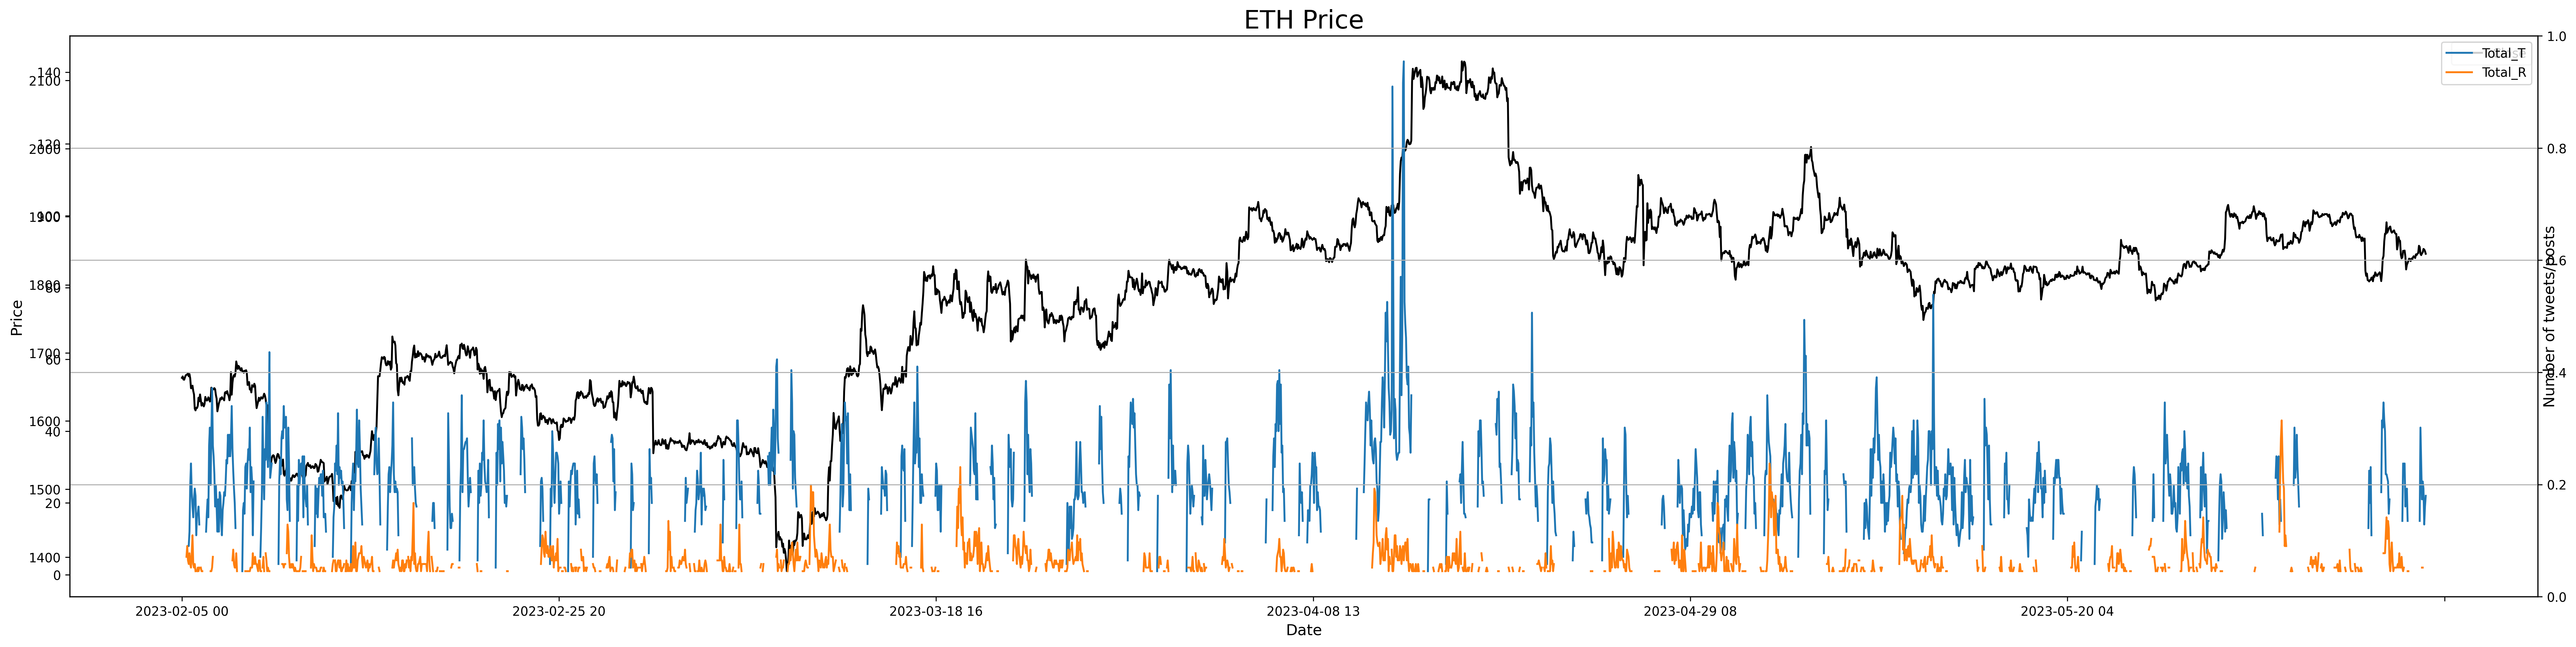

In [79]:
df1 = df.copy()
df2 = df.copy()
df1.loc[df["Total_T"] == 0, "Total_T"] = np.nan
df2.loc[df["Total_R"] == 0, "Total_R"] = np.nan

fig = plt.figure(figsize = (35,8), dpi=300)
df.plot(x="DateTime", y="Close", ax=plt.gca(), color='black')
ax = plt.gca()
ax1 = ax.twinx()
df1.plot(x="DateTime", y="Total_T", ax=ax1)
ax2 = ax1.twinx()
df2.plot(x="DateTime", y="Total_R", ax=ax1)
ax.set_ylabel('Price', fontsize = 12 )
ax.set_xlabel('Date', fontsize = 12 )
ax1.set_ylabel('Number of tweets/posts', fontsize = 12 )
plt.title('ETH Price', fontsize = 20)
ax.legend()
ax1.legend()
plt.grid()
plt.show()